# Hyperparameters Database

### Authors : Bhavya Manvitha J, Manogjna Sindhu P

### Objective

The hyperparameter database is a public resource with algorithms, tools, and data that allows users to visualize and understand how to choose hyperparameters that maximize the predictive power of their models. 
The hyperparameter database is created by running millions of hyperparameter values, over thousands of public datasets and calculating the individual conditional expectation of every hyperparameter on the quality of a model. 

The outcome of the project involves delivering the best hyperparameters for every model obtained through running H2O on the choosen dataset.The algorithm generates a leaderboard of best models ranked according to their efficiency.H2O analyzes the models like Distributed Random Forest (DRF), Generalized Linear Model (GLM), Gradient Boosting Machine (GBM). Naïve Bayes Classifier, Stacked Ensembles, Xgboost.The best hyperparameters from these models are determined using grid search.
 

### Understanding the terms

#### Hyperparameters

Hyperparameters are parameters that are specified prior to running machine learning algorithms that have a large effect on the predictive power of statistical models.Hyperparameters are important because they directly control the behaviour of the training algorithm and have a significant impact on the performance of the model is being trained.

Choosing good hyperparameters gives two benefits:
Efficiently search the space of possible hyperparameters
Easy to manage a large set of experiments for hyperparameter tuning.

#### H2O

It is an open source, in-memory, distributed, ML and predictive analytics platform that allows us to build and productionize ML models.It Contains supervised and unsupervised models and interfaces for R,Python,Scala,Java,JSON,Javascript. 

#### Grid Search

The process of finding most optimal hyperparameters in machine learning is called hyperparameter optimisation.Grid search is one common algorithm.In this technique, we build a model for every combination of various hyperparameters and evaluate each model. The model which gives the highest accuracy is choosen.

#### Gradient Boost

Gradient boosting is a machine learning technique for regression and classification problems.It produces a prediction model in the form of ensemble models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods and generalizes them by using loss functions.

#### Generalised Linear Model

GLM is a flexible generalization of ordinary linear regression that allows response variables that have error distribution models other than a normal distribution.It generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

#### Extremely Randomized Trees

Adding one further step of randomization to Random forests yields extremely randomized trees or ExtraTrees.Each tree is trained using the whole learning sample (rather than a bootstrap sample), and the top-down splitting in the tree learner is randomized. 

#### Distributed Random Forests

DRF is a powerful classification and regression tool. When given a set of data, DRF generates a forest of classification or regression trees rather than a single tree. Each of these trees is a weak learner built on a subset of rows and columns. More trees will reduce the variance. Both classification and regression take the average prediction over all of their trees to make a final prediction for both class and numeric value.

## Code and Documentation

### Library imports

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import random, os, sys
from datetime import datetime
import time

#H2O imports:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

import warnings
warnings.filterwarnings('ignore')

### Dataset import

In [ ]:
df=pd.read_csv("indian_liver_patient.csv", sep=',')

### Data Cleaning 

In [ ]:
The following steps are included in cleaning the data:
    
    df.head()                 #displays the 5 rows
    df.shape                  #shapes the data array
    df.dtypes                 #to check datatypes
    df.isnull().sum()         #checking for nulls
    fill = df['Albumin_and_Globulin_Ratio']
Albumin_and_Globulin_Ratio = fill.fillna(fill.median(),inplace=True)  #filling nulls with median

#### setting the components to run H2O

In [ ]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=5,port=port_no)

target = 'Dataset'
run_time=1200
pct_memory=0.5
server_path=None 
data_path=None
all_variables=None
test_path=None
model_path=None
nthreads=1 
name=None 
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
run_id='SOME_ID_20180617_221529' # Just some arbitrary ID
classification=True
scale=False
max_models=None
balance_y=False # balance_classes=balance_y
balance_threshold=0.2
project ="automl_test"
analysis=0

#### defining functions

In [ ]:
def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str


def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def automl(maxruntime,X,Y,df):
    aml = H2OAutoML(max_runtime_secs=maxruntime,exclude_algos = ['DeepLearning', 'StackedEnsemble'])
    aml.train(x=X,y=y,training_frame=df)
    return aml


def dict_to_json(dct,n):  
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

#### generating unique ID for each runtime

In [ ]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

#### setting target variable

In [ ]:
y = target
X=[name for name in df.columns if name != y]
print(X)
print(y)
meta_data['X']=X  
model_start_time = time.time()


#since our problem is classification
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True
if classification:
    df[y] = df[y].asfactor()
    classification=True
if classification:
    print(df[y].levels())

### Running automl for runtime=1200 

In [ ]:
aml5 = automl(1200,X,y,df)
meta_data['run_time'] = 1200
meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
aml5.leaderboard
aml5_leaderboard_df=aml5.leaderboard.as_data_frame()
aml5_leaderboard_df
length = len(aml5_leaderboard_df)
length
meta_data["models_generated"] = length
leaderboard_stats=run_id+ '1200sec'+ '_leaderboard.csv'
aml5_leaderboard_df.to_csv(leaderboard_stats)
aml5_leaderboard_df=aml5.leaderboard.as_data_frame()
model5_set=aml5_leaderboard_df['model_id']
model5_set


#### getting the best parameters

In [ ]:
count = 0;
for i in model5_set:
    count = count+1;
for i in range(0,count):
    mod_best=h2o.get_model(model5_set[i])
    parameters = mod_best.params
    n= str((model5_set[i]))+'__1200'
    dict_to_json(parameters,n)
    
    n=run_id+'_meta_data.json'    #saving parameters into json file
dict_to_json(meta_data,n)


#### meta data is obtained as such

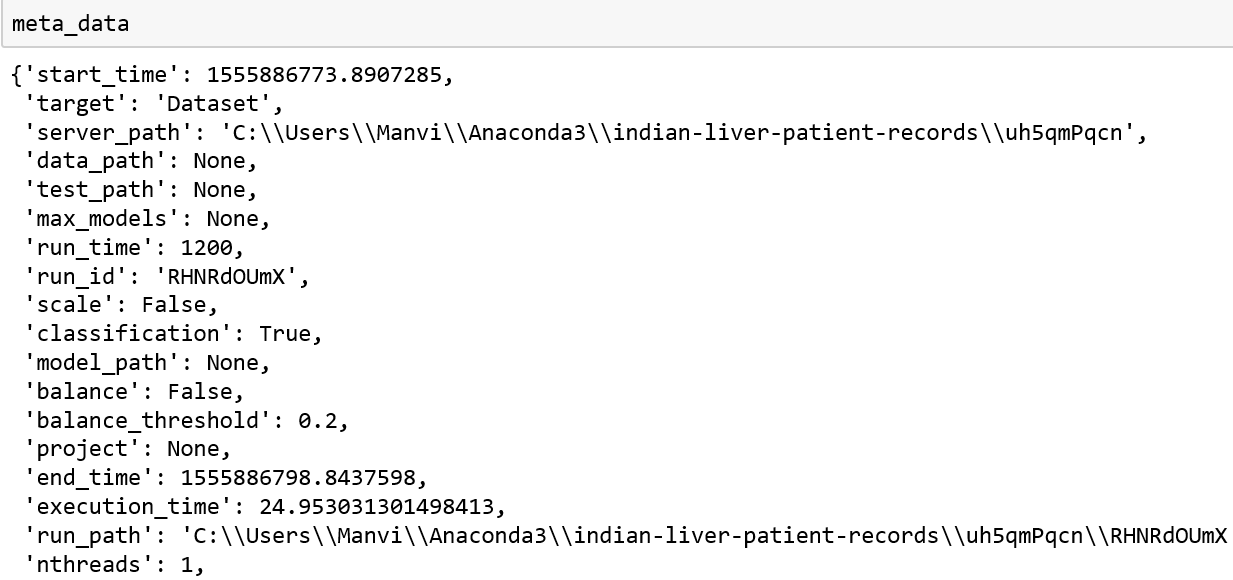

## Hyperparameter ranges

In [ ]:
range_mtries = [df_drf['mtries'].min(),df_drf['mtries'].max()]     
range_mtries
ntrees = [df_drf['ntrees'].min(),df_drf['ntrees'].max()]
ntrees
seed = [df_drf['seed'].min(),df_drf['seed'].max()]
seed  #similarly find for all the obtained hyperparameters                                                 

#### the following function can also be used for large set of hyperparameters

In [ ]:
ranges = []
for key,val in df_gbm.dtypes.items():
    print(key,val)
    if val == 'int64': 
         ranges.append([key,[df_gbm[key].min(),df_gbm[key].max()]])
    ##if val == 'float64':
      ##   ranges.append([key,[df_gbm[key].min(),df_gbm[key].max()]])
    if val == 'object':
         ranges.append([key,[df_gbm[key].min(),df_gbm[key].max()]])

#### ranges are obtained as:

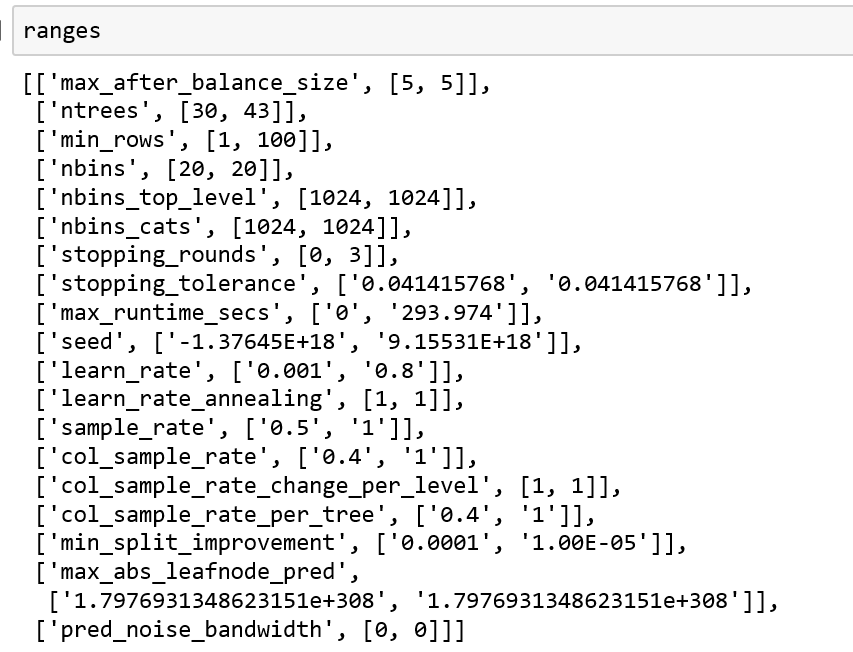

## Results

#### Hyperparameters are obtained as follows

### DRF

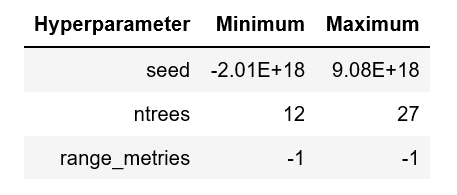

### GBM

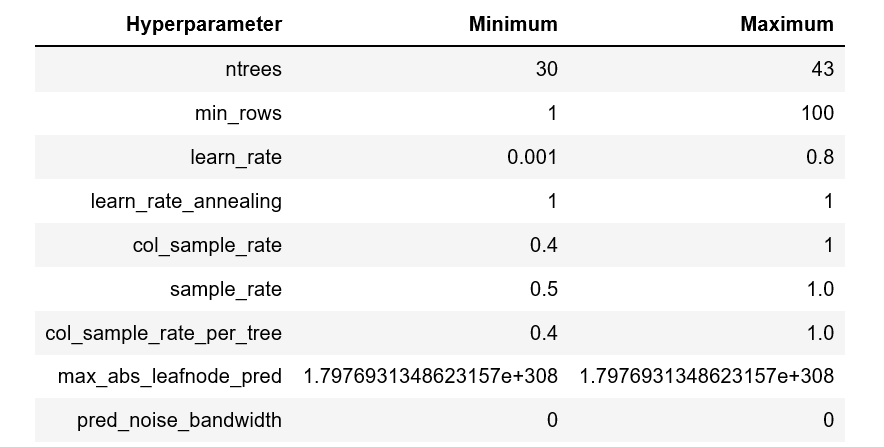

### GLM

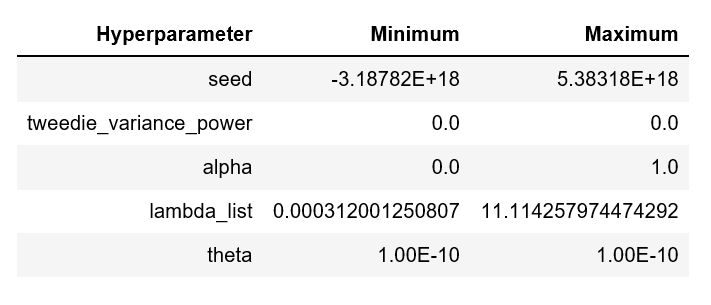

### XRT

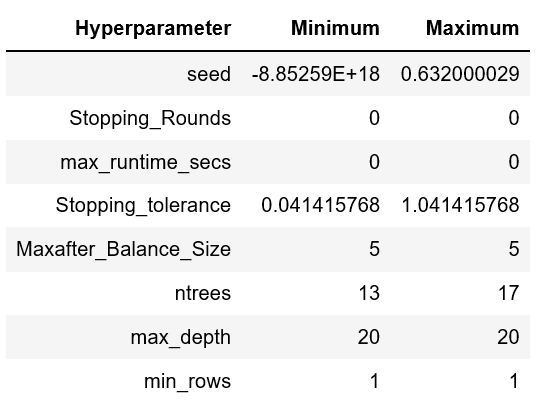

## Conclusion

The best hyperparameters are found out using grid search.Their ranges are also determined for various algorithms like GBM,GLM,XRT,DRF. For runtimes 300sec,500sec,800sec,1000sec,1200sec. Using these hyperparameters increases the efficiency of the model

## References

https://github.com/INFO6105-Spring19/hyperparameter-db-project-ds03.git

https://github.com/nikbearbrown/INFO_6105/blob/master/Projects-Portolios/Object%20Detection%20using%20TensorFlow/Project/Portfolio.ipynb

## Contribution

Performed H2O and derived hyperparameters

self- 70%

internet - 30%

## License

Copyright 2019 Manogjna Potluri 

Copyright 2019 Manvitha Jagadam


Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
